LSTM

In [1]:
from datetime import datetime, timedelta
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [2]:
acao = 'MGLU3.SA'

ativo = yf.download(acao, period="5y")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
ativo.head()

Price,Close,High,Low,Open,Volume
Ticker,MGLU3.SA,MGLU3.SA,MGLU3.SA,MGLU3.SA,MGLU3.SA
Date,,,,,
2020-02-28,117.789597,117.789597,110.095496,114.245649,8424808
2020-03-02,122.522629,124.597701,116.157513,118.209269,6907942
2020-03-03,123.222092,127.768601,120.470865,122.825727,6242974
2020-03-04,122.289474,126.975875,120.937181,126.835984,4847778
2020-03-05,111.424484,121.240282,108.649949,121.240282,9064886


In [4]:
# Pega somente o atributo "Close" e armazena em um array bidimensional
#O array precisa ser bidimensional porque o MinMaxScaler espera uma entrada com esse formato.
ativo_close = ativo['Close'].dropna().to_numpy().reshape(-1, 1)

In [5]:
# Criar um DataFrame com os valores ajustados
data = pd.DataFrame(ativo_close)
data.columns = ['Close']

In [6]:
# Normalizar os dados para os modelos
scaler = MinMaxScaler(feature_range=(0, 1))
data['Scaled_Close'] = scaler.fit_transform(data[['Close']])

In [7]:
# Função para criar janelas de dados
# janela de dados = quantidade de dias do X
def create_dataset(data, window_size=60):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)


In [8]:
window_size = 30
scaled_data = data['Scaled_Close'].values
X, y = create_dataset(scaled_data, window_size)

In [9]:
scaled_data.shape, X.shape, y.shape

((1247,), (1217, 30), (1217,))

In [10]:
# Dividir os dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [11]:
# Ajustar o formato para o LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [12]:
model = Sequential([
    Input(shape=(window_size, 1)),  # Definir a entrada explicitamente
    LSTM(100, return_sequences=True),
    Dropout(0.3),
    LSTM(100, return_sequences=True),
    Dropout(0.3),
    LSTM(100),
    Dropout(0.3),
    Dense(1)
])

In [13]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')


In [14]:
# Treinar o modelo
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

model.fit(X_train, y_train, 
               epochs=100, 
               batch_size=32, 
               validation_data=(X_test, y_test),
               callbacks=[early_stopping, reduce_lr], 
               verbose=1)


Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 0.0732 - val_loss: 1.1425e-04 - learning_rate: 0.0010
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0045 - val_loss: 1.2148e-04 - learning_rate: 0.0010
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0042 - val_loss: 3.7602e-05 - learning_rate: 0.0010
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0038 - val_loss: 4.4722e-05 - learning_rate: 0.0010
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0034 - val_loss: 2.3448e-05 - learning_rate: 0.0010
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0035 - val_loss: 2.3044e-05 - learning_rate: 0.0010
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0038 - val_loss: 2.5415e-05 - learning_rate: 5.0000e-04
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0033 - val_loss: 2.0157e-05 - learning_rate: 5.0000e-04
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0034 - val_loss: 2

In [15]:
# Fazer previsões
lstm_predictions = model.predict(X_test)

# Inverter a normalização
lstm_predictions = scaler.inverse_transform(lstm_predictions)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


In [16]:
df_teste = pd.DataFrame({
    "Date": ativo.index[len(X_train) + window_size : len(X_train) + window_size + len(lstm_predictions)],
    "Real": ativo['Close'].iloc[len(X_train) + window_size : len(X_train) + window_size + len(lstm_predictions)].values.flatten(),
    "Previsão": lstm_predictions.flatten()
})

df_teste["Date"] = pd.to_datetime(df_teste["Date"])

df_teste.set_index("Date", inplace=True)

In [17]:
df_teste

,Real,Previsão
Date,,
2024-03-13,20.299999,20.401594
2024-03-14,20.100000,20.302927
2024-03-15,19.600000,20.187370
2024-03-18,21.000000,20.059591
2024-03-19,19.700001,19.944830
...,...,...
2025-02-24,6.870000,7.313400
2025-02-25,7.380000,7.327448
2025-02-26,7.360000,7.331292


In [18]:
# Calcular métricas
mae = mean_absolute_error(df_teste["Real"], df_teste["Previsão"])
mse = mean_squared_error(df_teste["Real"], df_teste["Previsão"])
rmse = np.sqrt(mse)
r2 = r2_score(df_teste["Real"], df_teste["Previsão"])

# Exibir resultados
print(f"📊 MÉTRICAS DE ERRO DO MODELO LSTM 📊")
print(f"MAE  (Erro Absoluto Médio)  : {mae:.4f}")
print(f"MSE  (Erro Quadrático Médio): {mse:.4f}")
print(f"RMSE (Raiz do Erro Médio)   : {rmse:.4f}")
print(f"R²   (Coeficiente de Determinação): {r2:.4f}")


📊 MÉTRICAS DE ERRO DO MODELO LSTM 📊
MAE  (Erro Absoluto Médio)  : 0.8049
MSE  (Erro Quadrático Médio): 1.0252
RMSE (Raiz do Erro Médio)   : 1.0125
R²   (Coeficiente de Determinação): 0.9175


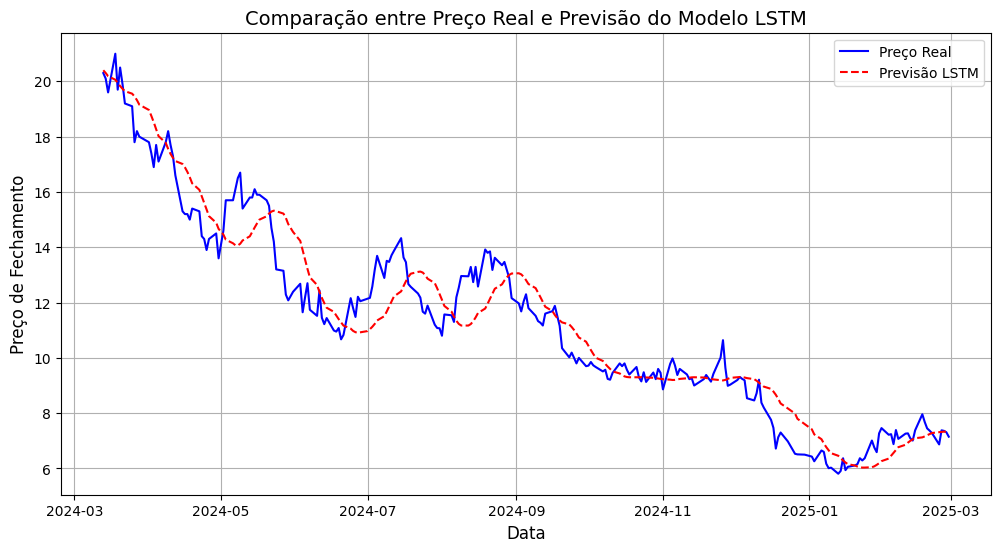

In [19]:
import matplotlib.pyplot as plt

# Criar o gráfico
plt.figure(figsize=(12, 6))
plt.plot(df_teste.index, df_teste["Real"], label="Preço Real", linestyle="-", color="blue")
plt.plot(df_teste.index, df_teste["Previsão"], label="Previsão LSTM", linestyle="--", color="red")

# Adicionar títulos e legendas
plt.title("Comparação entre Preço Real e Previsão do Modelo LSTM", fontsize=14)
plt.xlabel("Data", fontsize=12)
plt.ylabel("Preço de Fechamento", fontsize=12)
plt.legend()
plt.grid(True)

# Mostrar o gráfico
plt.show()


In [20]:
#calcular media de acertos e expectativa de lucro

df_teste = df_teste.copy()

df_teste['Variação percentual real'] = df_teste['Real'].pct_change()

#Nova coluna com a variação percentual da ação prevista
df_teste['Variação percentual previsão'] = df_teste['Previsão'].pct_change()

#Remover valores nulos
df_teste = df_teste.dropna()

#Nova coluna com a informação se a ação subiu ou não
df_teste['Ação subiu'] = np.where(df_teste['Variação percentual real'] > 0, 
                                                      True, False)

#Nova coluna com a informação se a previsão subiu ou não
df_teste['Previsão subiu'] = np.where(df_teste['Variação percentual previsão'] > 0, 
                                                      True, False)

#Nova coluna com a informação se o modelo acertou a tendência
df_teste['Modelo acertou tendência'] = np.where(df_teste['Ação subiu'] == df_teste['Previsão subiu']
                                      , True, False)

#Nova coluna com a variação percentual real absoluta
df_teste['Variação percentual real absoluto'] = df_teste['Variação percentual real'].abs()

#calcular media de acertos e expectativa de lucro
acertou_lado = df_teste['Modelo acertou tendência'].sum()/len(df_teste['Modelo acertou tendência'])

#calcular media de erros e expectativa de lucro
errou_lado = 1 - acertou_lado

#calcular media de lucro agrupado por acertos e erros
media_lucro = df_teste.groupby('Modelo acertou tendência')['Variação percentual real absoluto'].mean()

#calcular media de acertos e expectativa de lucro
acertou_lado = df_teste['Modelo acertou tendência'].sum()/len(df_teste['Modelo acertou tendência'])

#calcular media de erros e expectativa de lucro
errou_lado = 1 - acertou_lado

#calcular media de lucro agrupado por acertos e erros
media_lucro = df_teste.groupby('Modelo acertou tendência')['Variação percentual real absoluto'].mean()

#calcular expectativa matematica de lucro
exp_mat_lucro = acertou_lado * media_lucro[1] - media_lucro[0] * errou_lado

#calcular ganho sobre perda
ganho_sobre_perda = media_lucro[1]/media_lucro[0]

#calcular rendimento diario
exp_mat_lucro_percent = exp_mat_lucro * 100

print(f"Media lucro: {media_lucro}")
print(f"Ganho sobre perda: {ganho_sobre_perda}")
print(f"Acertou lado: {acertou_lado}")
print("rendimento diário: " + str(round(exp_mat_lucro_percent, 4)) + "%")


Media lucro: Modelo acertou tendência
False    0.033495
True     0.030503
Name: Variação percentual real absoluto, dtype: float64
Ganho sobre perda: 0.9106844211261337
Acertou lado: 0.5390946502057613
rendimento diário: 0.1006%


C:\Users\ramon\AppData\Local\Temp\ipykernel_23392\3695083697.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  exp_mat_lucro = acertou_lado * media_lucro[1] - media_lucro[0] * errou_lado
C:\Users\ramon\AppData\Local\Temp\ipykernel_23392\3695083697.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ganho_sobre_perda = media_lucro[1]/media_lucro[0]


In [21]:
data_hoje = datetime.now()

data_inicio_modelo = ativo.index[0]

if data_hoje.hour > 18:
    final = data_hoje
    inicial = datetime.now() - timedelta(days = 252)
    indicativo_dia = "\nPreço de fechamento amanhã:"
    
else:
    final = data_hoje - timedelta(days = 1)
    inicial = datetime.now() - timedelta(days = 252)
    indicativo_dia = "\nPreço de fechamento hoje:"
    

cotacoes = yf.download(acao, start=inicial, end=final)

ultimos_60_dias = cotacoes['Close'].iloc[-60:].values.reshape(-1, 1)

ultimos_60_dias_df = pd.DataFrame(ultimos_60_dias, columns=scaler.feature_names_in_)
ultimos_60_dias_escalado = scaler.transform(ultimos_60_dias_df)


teste_x = []
teste_x.append(ultimos_60_dias_escalado)
teste_x = np.array(teste_x)
teste_x = teste_x.reshape(teste_x.shape[0], teste_x.shape[1], 1)


previsao_de_preco = model.predict(teste_x)
previsao_de_preco   = scaler.inverse_transform(previsao_de_preco)

print(indicativo_dia)
print(previsao_de_preco[0][0])



[*********************100%***********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step

Preço de fechamento hoje:
7.6132154
